#  Прогнозирование заказов такси
___
# Forecasting taxi orders

Компания из сферы услуг такси собрала данные о заказах такси в различных аэропортах. Для привлечения большего количества водителей в период пиковой нагрузки необходимо спрогнозировать количество заказов на последующий час.

Необходимо построить модель, которая позволит сделать подобное предсказание.
___
A taxi service company collected data on taxi bookings at various airports. To attract more drivers during the peak period, it is necessary to predict the number of orders for the next hour.

It is necessary to build a model that will allow such a prediction to be made.

## Подготовка данных
___
## Data preparation

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [2]:
data = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
data

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


Проверим монотонноть индекса.
___
Let's check the monotonicity of the index.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
print(data.index.is_monotonic)

True


Данные упорядочены по временной оси.
___
The data is ordered along the time axis.

Сделаем ресемплинг по одному часу.
___
Let's do resampling for one hour.

In [6]:
data = data.resample('1H').mean()

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   num_orders  4416 non-null   float64
dtypes: float64(1)
memory usage: 69.0 KB


In [8]:
data.duplicated().sum()

4165

Дубликаты имеются однако это может быть характерной чертой представленных данных в силу большого количества повторов. Количество заказов в определенный момент времени может быть одинаковым в разных точках.
___
There are duplicates, however, this may be a characteristic feature of the presented data due to the large number of repetitions. The number of orders at a certain point in time can be the same at different points.

In [9]:
data.isna().sum()

num_orders    0
dtype: int64

Пропуски отсутствуют.

## Анализ
___
## Analysis

Проведем анализ данных. В первую очередь посмотрим сколзящее среднее. Возьмем в качестве значения окна - 10.
___
Let's analyze the data. Let's look at the moving average first. Let's take 10 as the value of the window.

<AxesSubplot:xlabel='datetime'>

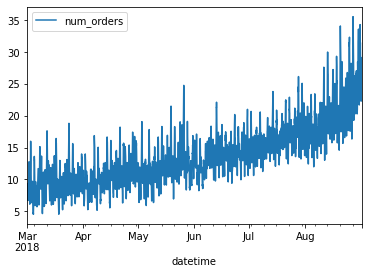

In [10]:
data.rolling(10).mean().plot()

In [11]:
decomposed = seasonal_decompose(data) 

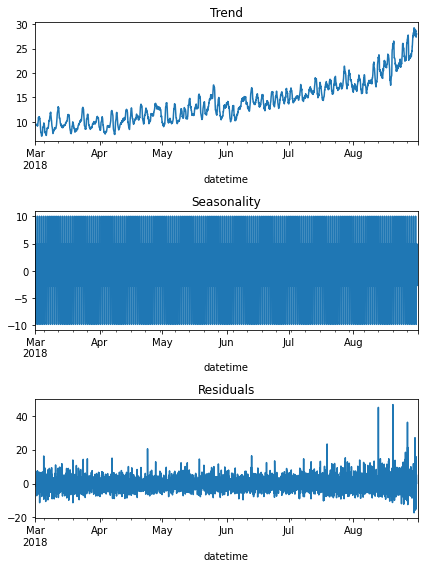

In [12]:
plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Из графика видно, что тренд состоит в плавном росте количества заказов, начиная с марта.

Посмотрим далее сезонность на промежутке равном 7 дней.
___
It can be seen from the graph that the trend consists in a smooth increase in the number of orders starting from March.

Let's look further at the seasonality on the interval equal to 7 days.

<AxesSubplot:title={'center':'Seasonal'}, xlabel='datetime'>

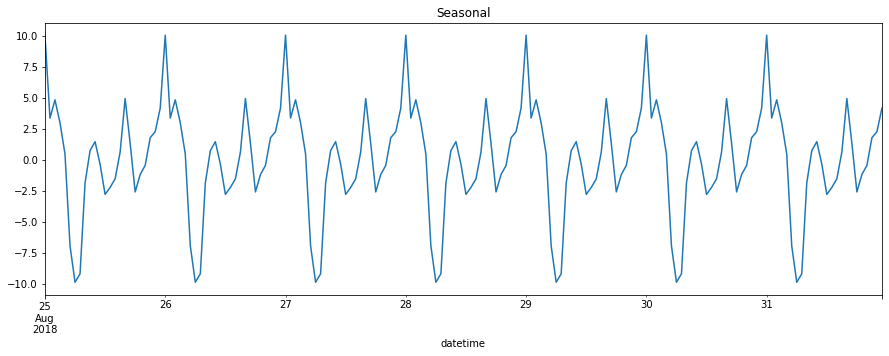

In [13]:
decomposed.seasonal.tail(24*7).plot(title='Seasonal', figsize=(15, 5))

Из графика видно 3 пика количества заказов, которые приходятся на начало рабочего дня, обеденное время, и вечернее.
___
The graph shows 3 peaks in the number of orders that fall at the beginning of the working day, lunchtime, and evening.

<AxesSubplot:title={'center':'Seasonal'}, xlabel='datetime'>

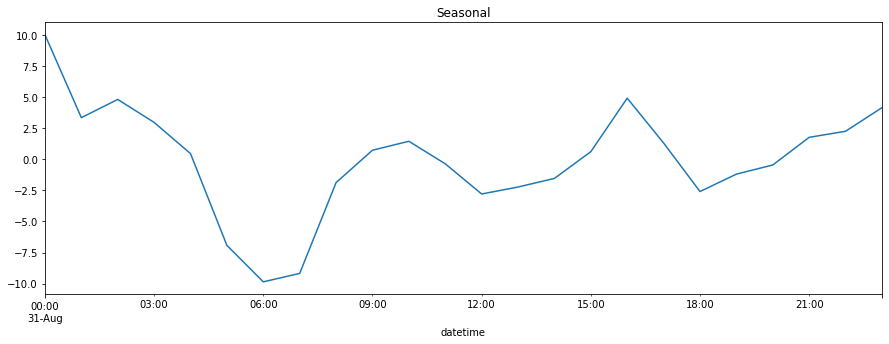

In [14]:
decomposed.seasonal.tail(24).plot(title='Seasonal', figsize=(15, 5))

Более детально можно увидеть динамику количества заказов в течение дня на 24-часовой временной оси.

Уточнение: пики в 9-10, 15-16 часов и в полночь.
___
In more detail, you can see the dynamics of the number of orders during the day on the 24-hour time axis.

Clarification: peaks at 9-10, 15-16 hours and at midnight.

Посмотрим ряд на стационарность.
___
Let's look at the stationarity series.

<AxesSubplot:xlabel='datetime'>

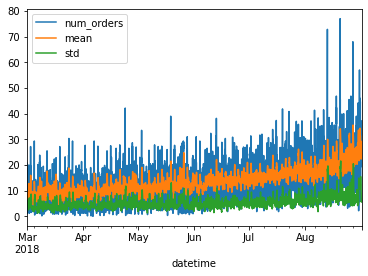

In [15]:
data['mean'] = data['num_orders'].rolling(10).mean()
data['std'] = data['num_orders'].rolling(10).std()
data.plot()

Ряд нестационарный, соответственно для построения прогноза необходимо сделать его таковым. Для этого найдем разности временного ряда, так как они более стационарны.
___
The series is non-stationary, therefore, to build a forecast, it is necessary to make it such. To do this, we find the differences in the time series, since they are more stationary.

In [16]:
data -= data.shift(fill_value=0)

Проверим на графике.
___
Let's check the chart.

<AxesSubplot:xlabel='datetime'>

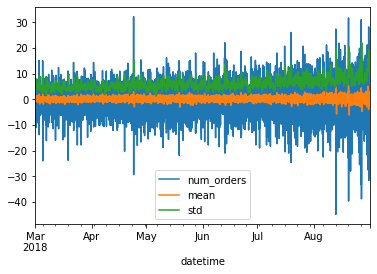

In [17]:
data['mean'] = data['num_orders'].rolling(10).mean()
data['std'] = data['num_orders'].rolling(10).std()
data.plot()

## Обучение
___
## Training

Создадим функцию для создания признаков.
___
Let's create a function to create features.

In [18]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [19]:
make_features(data, 6, 6)

In [20]:
train, test = train_test_split(data, shuffle=False, test_size=0.2)
train = train.dropna()

train_features = train.drop(['num_orders'], axis=1)
train_target = train['num_orders']
test_features = test.drop(['num_orders'], axis=1)
test_target = test['num_orders']

Обучим модели.
___
Let's train the models.

**Линейная регрессия**
___
**Linear regression**

In [21]:
tscv = TimeSeriesSplit(n_splits=3)
model_lr = LinearRegression()
parameters = {"fit_intercept": [True, False], "normalize": [True, False]}
grid_lr = GridSearchCV(model_lr, param_grid=parameters, cv=tscv, scoring='neg_root_mean_squared_error', refit=True)
grid_lr.fit(train_features, train_target)
params_lr = grid_lr.best_params_
grid_lr_best = LinearRegression(**params_lr)
grid_lr_best

LinearRegression(fit_intercept=False, normalize=True)

**Случайный лес**
___
**Random Forest**

In [22]:
params_rfr = {"max_depth": range(1, 20, 5)}

model_rfr = RandomForestRegressor(random_state=12345)

grid_rfr = GridSearchCV(model_rfr, params_rfr, cv=tscv, n_jobs=-1, verbose=2, scoring='neg_root_mean_squared_error')
grid_rfr.fit(train_features, train_target)
params_rfr = grid_rfr.best_params_
grid_rfr_best = RandomForestRegressor(**params_rfr, random_state=12345)
grid_rfr_best

Fitting 3 folds for each of 4 candidates, totalling 12 fits


RandomForestRegressor(max_depth=16, random_state=12345)

**Дерево решений**
___
**Decision Tree**

In [23]:
params_dtr = {"max_depth": range(1, 6)}

model_dtr = DecisionTreeRegressor(random_state=12345)

grid_dtr = GridSearchCV(
    model_dtr, param_grid=params_dtr, cv=tscv, scoring='neg_root_mean_squared_error', refit=True
)
grid_dtr.fit(train_features, train_target)
params_dtr = grid_dtr.best_params_
grid_dtr_best = DecisionTreeRegressor(**params_dtr, random_state=12345)
grid_dtr_best

DecisionTreeRegressor(max_depth=5, random_state=12345)

## Тестирование
___
## Testing

Произведем тестирование модели.
___
Let's test the model.

In [24]:
grid_lr_best.fit(train_features, train_target)
test_pred_lr = grid_lr_best.predict(test_features)
rmse_lr = mean_squared_error(test_pred_lr, test_target, squared= False)
print("RMSE lr: ", rmse_lr)

RMSE lr:  6.562817346024773


In [25]:
grid_rfr_best.fit(train_features, train_target)
test_pred_rfr = grid_rfr_best.predict(test_features)
rmse_rfr = mean_squared_error(test_pred_rfr, test_target, squared= False)
print("RMSE rfr: ", rmse_rfr)

RMSE rfr:  6.445773572316985


In [26]:
grid_dtr_best.fit(train_features, train_target)
test_pred_dtr = grid_dtr_best.predict(test_features)
rmse_dtr = mean_squared_error(test_pred_dtr, test_target, squared= False)
print("RMSE dtr: ", rmse_dtr)

RMSE dtr:  7.62610789659467


In [27]:
table = [
    [
        rmse_lr,
        rmse_rfr,
        rmse_dtr
    ]
]
columns = ["lr", "rfr", "dtr"]
index = ["RMSE"]
table = pd.DataFrame(table, index, columns)
display(table)

,lr,rfr,dtr
RMSE,6.562817,6.445774,7.626108


Объективно наиболее эффективный метод - Дерево решений.
___
Objectively, the most efficient method is the Decision Tree.

**Выводы:**

- Тренд состоит в плавном росте количества заказов, начиная с марта;
- Пики количества заказов такси приходятся на 9-10, 15-16 часов и на полночь;
- Рекомендуемый метод обучения - случайный лес.
___
**Conclusions:**

- The trend is a gradual increase in the number of orders starting from March;
- The peaks of the number of taxi orders fall at 9-10, 15-16 and at midnight;
- The recommended training method is random forest.